<a href="https://colab.research.google.com/github/yeshwanthkonk/TelecomChurnPrediction_HybridModel_UVIC_503/blob/main/Churn_Prediction_Ensemble_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pickle
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
import os
import time
import matplotlib.pyplot as plt
import json
from sklearn.metrics import classification_report


from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve
)

## Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# load dataset from CSV
df = pd.read_csv('/content/drive/MyDrive/Collab_Files/Churn_Prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df_LR = df.copy()
df_DT = df.copy()
X = df.drop(columns="Churn")
y = df["Churn"]
y = y.map({'Yes': 1, 'No': 0})

with open("/content/drive/MyDrive/Collab_Files/Churn_Prediction/cross_validation_split.json", "r") as f:
    cv_data = json.load(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preproccess Data

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

def encode_data(df, df_y, ordinal):
  # Drop extraneous columns
  df = df.drop(columns=[c for c in ['Phone','Churn','customerID'] if c in df.columns])

  # Convert false objects to float
  df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

  if ordinal:
    df["Contract"] = df["Contract"].map({"Month-to-month": 0, "One year": 1, "Two year": 2})

  # Drop Missing Value + and drop those rows for labels
  original_index = df.index
  df = df.dropna()
  dropped_idx = original_index.difference(df.index)
  df_y = df_y.drop(index=dropped_idx)

  # Get categorical columns (excluding customerID which is just an identifier)
  categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

  # Create a copy of the dataframe for encoding and remove null data
  df_encoded = df.copy()

  # Method 1: Label Encoding for binary categorical variables
  binary_categorical = []
  multi_categorical = []

  # Identify binary vs multi-category variables
  for col in categorical_cols:
      unique_values = df[col].nunique()
      if unique_values == 2:
          binary_categorical.append(col)
      else:
          multi_categorical.append(col)

  # Apply Label Encoding to binary categorical variables
  label_encoders = {}
  for col in binary_categorical:
      le = LabelEncoder()
      df_encoded[col] = le.fit_transform(df[col])
      label_encoders[col] = le

  # Method 2: One-Hot Encoding for multi-categorical variables
  if multi_categorical:
      df_encoded = pd.get_dummies(df_encoded, columns=multi_categorical, prefix=multi_categorical, drop_first=True)

  bool_cols = df_encoded.select_dtypes(include='bool').columns
  df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)

  return df_encoded, df_y

def scale_data(train_np, test_np):
  # Apply Min-Max scaling to range [-1, 1]
  scaler = MinMaxScaler(feature_range=(-1, 1))
  train_scaled_np = scaler.fit_transform(train_np)
  test_scaled_np = scaler.transform(test_np)

  return train_scaled_np, test_scaled_np

X, y = encode_data(X, y, False)
X = X.values
y = y.values

In [ ]:
folds = cv_data["folds"]
test_indices = cv_data["test_indices"]

X_test = X[test_indices]
y_test = y[test_indices]

train_indices = folds[1][0] + folds[1][1]

X_train = X[train_indices]
y_train = y[train_indices]

X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

## Decision Tree Predictions

In [ ]:


# Convert 'TotalCharges' to numeric (force errors to NaN)
df_DT['TotalCharges'] = pd.to_numeric(df_DT['TotalCharges'], errors='coerce')

# Drop rows with missing TotalCharges
df_DT.dropna(subset=['TotalCharges'], inplace=True)

# Reset index after drop
df_DT.reset_index(drop=True, inplace=True)

# Drop irrelevant columns
df_DT.drop(['customerID'], axis=1, inplace=True)


# Encode target variable
df_DT['Churn'] = df_DT['Churn'].map({'No': 0, 'Yes': 1})

# One-hot encode categorical features (drop first to avoid multicollinearity)
df_DT = pd.get_dummies(df_DT, drop_first=True)


X_DT= df_DT.drop('Churn', axis=1)
y_DT = df_DT['Churn']


filename = f'/content/drive/MyDrive/Collab_Files/Churn_Prediction/decision_tree_model.pkl'
with open(filename, 'rb') as f:
    decision_tree = pickle.load(f)

y_pred_dt = decision_tree.predict(X_DT.iloc[test_indices])
print(classification_report(y_test, y_pred_dt))

   SeniorCitizen  tenure  MonthlyCharges  TotalCharges  Churn  gender_Male  \
0              0       1           29.85         29.85      0        False   
1              0      34           56.95       1889.50      0         True   
2              0       2           53.85        108.15      1         True   
3              0      45           42.30       1840.75      0         True   
4              0       2           70.70        151.65      1        False   

   Partner_Yes  Dependents_Yes  PhoneService_Yes  \
0         True           False             False   
1        False           False              True   
2        False           False              True   
3        False           False             False   
4        False           False              True   

   MultipleLines_No phone service  ...  StreamingTV_No internet service  \
0                            True  ...                            False   
1                           False  ...                            Fa

## Random Forest Predictions

In [ ]:
filename = f'/content/drive/MyDrive/Collab_Files/Churn_Prediction/best_random_forest_model.pkl'
with open(filename, 'rb') as f:
    random_forest = pickle.load(f)

y_pred_rf = random_forest.predict(X_test_scaled)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88      1026
           1       0.73      0.53      0.61       381

    accuracy                           0.82      1407
   macro avg       0.79      0.73      0.75      1407
weighted avg       0.81      0.82      0.81      1407



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


## Logistic Regression Prediction

In [ ]:
from sklearn.preprocessing import StandardScaler
# --- Data Cleaning and Preprocessing ---
# Drop the unique customer ID as it's not a predictive feature
df_LR = df_LR.drop("customerID", axis=1)

df_LR['TotalCharges'] = pd.to_numeric(df_LR['TotalCharges'], errors='coerce')
df_LR.dropna(inplace=True)

# 'Churn' to binary (1 for 'Yes', 0 for 'No')
df_LR['Churn'] = df_LR['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

X_LR = df_LR.drop('Churn', axis=1)

# One-Hot Encode all categorical features
X_LR = pd.get_dummies(X_LR, drop_first=True)
print("Data preprocessing complete.")

X_LR_Train = X_LR.iloc[train_indices]
X_LR_Test = X_LR.iloc[test_indices]

# fit the scaler ONLY on the training data to prevent data leakage from the test set
scaler = StandardScaler()
X_train_scaled_LR = scaler.fit_transform(X_LR_Train)
X_test_scaled_LR = scaler.transform(X_LR_Test)


filename = f'/content/drive/MyDrive/Collab_Files/Churn_Prediction/best_logistic_regression_churn_model.pkl'
with open(filename, 'rb') as f:
    logistic_regression = pickle.load(f)

y_pred_lr = logistic_regression.predict(X_test_scaled_LR)
print(classification_report(y_test, y_pred_lr))
y_scores_lr = logistic_regression.predict_proba(X_test_scaled_LR)[:,1]

Data preprocessing complete.
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1026
           1       0.53      0.77      0.63       381

    accuracy                           0.75      1407
   macro avg       0.71      0.76      0.72      1407
weighted avg       0.80      0.75      0.76      1407



## Neural Network Prediction

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, classification_report

class SimpleNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleNet(X_train_scaled.shape[1]).to(device)

model.load_state_dict(torch.load('/content/drive/MyDrive/Collab_Files/Churn_Prediction/best_NN.pkl'))

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)

model.eval()
with torch.no_grad():
    y_pred_logits = model(X_test_tensor)
    y_pred_probs = torch.sigmoid(y_pred_logits)
    y_pred = (y_pred_probs >= 0.5).int()

y_scores_NN = y_pred_probs.cpu().numpy().reshape(-1)
y_pred_NN = y_pred.cpu().numpy().reshape(-1)
print(classification_report(y_test, y_pred_NN))

              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1026
           1       0.50      0.79      0.61       381

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.74      1407



In [ ]:
# Pair wise model similarity
from sklearn.metrics.pairwise import cosine_similarity
all_preds = np.stack((y_pred_dt, y_pred_rf, y_pred_lr, y_pred_NN))

similarity_matrix = cosine_similarity(all_preds)
print(similarity_matrix.shape)

(4, 4)


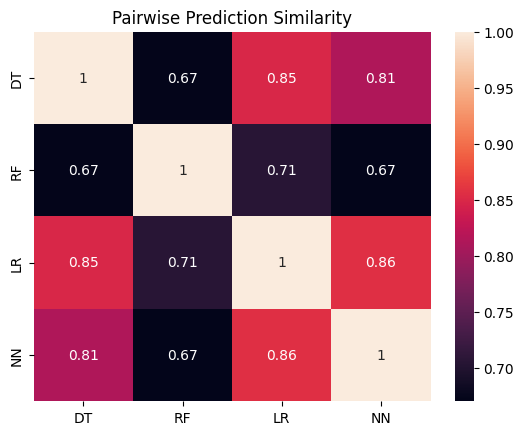

In [ ]:
# Plot with labels
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(similarity_matrix, annot=True, xticklabels=['DT', 'RF', 'LR', 'NN'], yticklabels=['DT','RF', 'LR', 'NN'])
plt.title('Pairwise Prediction Similarity')
plt.show()

## Vote and Predict

In [ ]:
all_preds = np.stack((y_pred_dt, y_pred_rf, y_pred_lr, y_pred_NN))
votes = np.sum(all_preds, axis=0)

final_preds = (votes >= 2).astype(int)

# Find tie indices
ties = (votes == 2)

# Break ties using scores from Logistic Regression and NN
# Use whichever has higher confidence (e.g., probability > 0.5)
# If both agree, default to positive class (1)

# Where ties exist, use score-based logic
for i in np.where(ties)[0]:
    # If the two scoring models agree then dont do anything
    if y_pred_NN[i] == y_pred_lr[i]:
        continue

    # If they disagree then see which is more confident
    else:
      confidence_lr = abs(0.5 - y_scores_lr[i])
      confidence_NN = abs(0.5 - y_scores_NN[i])
      if confidence_lr < confidence_NN:
        final_preds[i] = y_pred_NN[i]
      else:
        final_preds[i] = y_pred_lr[i]

print(classification_report(y_test, final_preds))

              precision    recall  f1-score   support

           0       0.90      0.76      0.83      1026
           1       0.55      0.76      0.64       381

    accuracy                           0.76      1407
   macro avg       0.72      0.76      0.73      1407
weighted avg       0.80      0.76      0.77      1407



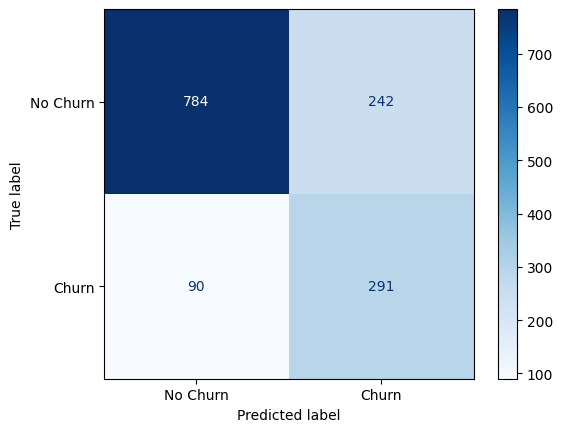

In [ ]:
#Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn", "Churn"])
disp.plot(cmap='Blues')